# Markov Decision Prcess aproach

- define State

Represent point process with simple graphycal model.

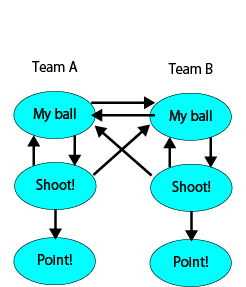

- calcurate each transiction probabilities

To use detail data, calcurate transiction probabilities and create transiction matrix

- simulate and get win probability

Monte-carlo simulation


In [ ]:
import numpy as np
import pandas as pd
import os

pd.set_option("display.max_column", 999)
print(os.listdir("../input"))

# Data preparation and preprocess



In [ ]:
dir_path = '../input/womens-march-mania-2022'
data_head = 'W'
tourney_results = pd.read_csv(f'{dir_path}/{data_head}DataFiles_Stage1/{data_head}NCAATourneyDetailedResults.csv')
seeds = pd.read_csv(f'{dir_path}/{data_head}DataFiles_Stage1/{data_head}NCAATourneySeeds.csv')
regular_results = pd.read_csv(f'{dir_path}/{data_head}DataFiles_Stage1/{data_head}RegularSeasonDetailedResults.csv')

def preprocess_csv(regular_results:pd.DataFrame):
    regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
    # 2pt goal
    regular_results['WFGM2'] = regular_results['WFGM'] - regular_results['WFGM3']
    regular_results['WFGA2'] = regular_results['WFGA'] - regular_results['WFGA3']

    regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
    # 2pt goal
    regular_results['LFGM2'] = regular_results['LFGM'] - regular_results['LFGM3']
    regular_results['LFGA2'] = regular_results['LFGA'] - regular_results['LFGA3']
    return regular_results

# tourney_results.Season.unique()
columns_list = ['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FGM2', 'T1_FGA2','T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FGM2', 'T2_FGA2','T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF']

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFGM2', 'LFGA2', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3','WFGM2', 'WFGA2','WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output.reindex(columns=columns_list)
    return output

    

In [ ]:
len(regular_results)

In [ ]:
regular_results = preprocess_csv(regular_results)
regular_data = prepare_data(regular_results)

In [ ]:
tourney_results.Season.unique()
tourney_results = preprocess_csv(tourney_results)
tourney_data = prepare_data(tourney_results)

In [ ]:
regular_data.head()

In [ ]:
tourney_data.head(1)

In [ ]:
regular_data.columns

In [ ]:
regular_data.isnull().sum()

# create State
- Ball : keeping the ball

- Shoot : shooting

- Point : get point.

Shoot and Point states are 3 kinds, 3pt, 2pt and 1pt(Free throw).

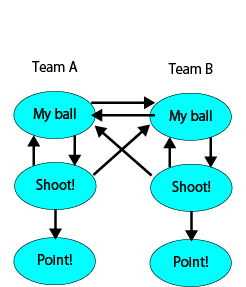

In [ ]:
def create_state_lists():
    index_list = ["ball_1", "ball_2"]
    for state in ["sh", "pt"]:
        for pt in ["3", "2", "1"]:
            index_list.append(f"{state}_{pt}_1")
            index_list.append(f"{state}_{pt}_2")
    return index_list

In [ ]:
state_list = create_state_lists()

In [ ]:
state_list

In [ ]:
def create_trasiction_probability(state_list):
    dim = len(state_list)
    transiction_mtx_df = pd.DataFrame(
        data=np.zeros((dim, dim)),
        index=state_list,  #['s_1', 'a_F_a_1', 'a_F_a_1'],
        columns=state_list
    )
    return transiction_mtx_df

# ポイントの確率は1に設定
def set_pt_prob(df):
    state = "pt"
    for pt in ["3", "2", "1"]:
        df.at[f"{state}_{pt}_1", f"{state}_{pt}_1"] = 1
        df.at[f"{state}_{pt}_2", f"{state}_{pt}_2"] = 1  
    return df

In [ ]:
row = tourney_data.head(1)

#### transition matrix

In [ ]:
create_trasiction_probability(state_list)

### Update transition matrix

From statistical data, update matrix values

In [ ]:
def get_ball_trans_probability(trans_df, row, ft_val=2):
    for team_num in range(1, 3):
        state = "sh"
        opp_num = 3 - team_num
        ft_num = int(row[f"T{team_num}_FTA"] / ft_val)
        turn_over_num = int(row[f"T{team_num}_TO"])
        total_sh = int(row[f"T{team_num}_FGA"]) + ft_num + turn_over_num
        # FT
        trans_df.at[f"ball_{team_num}", f"{state}_1_{team_num}"] = ft_num / total_sh
        # opp_ball
        trans_df.at[f"ball_{team_num}", f"ball_{opp_num}"] = turn_over_num / total_sh
        for pt in ["3", "2"]:
            trans_df.at[f"ball_{team_num}", f"{state}_{pt}_{team_num}"] = row[f"T{team_num}_FGA{pt}"] / total_sh
    return trans_df

def get_shoot_trans_probability(trans_df, row, ft_val=2):
    for team_num in range(1, 3):
        current_state = "sh"
        opp_num = 3 - team_num
        # rebound
        rebound_num = int(row[f"T{team_num}_OR"]) + int(row[f"T{opp_num}_DR"])
        or_rate = int(row[f"T{team_num}_OR"]) / rebound_num
        dr_rate = int(row[f"T{opp_num}_DR"]) / rebound_num
        for pt in ["3", "2", "1"]:
            if pt == "1":
                success_rate = int(row[f'T{team_num}_FTM']) / int(row[f'T{team_num}_FTA']) if int(row[f'T{team_num}_FTA']) > 0 else 0
            else:    
                success_rate = int(row[f'T{team_num}_FGM{pt}']) / int(row[f'T{team_num}_FGA{pt}']) if int(row[f'T{team_num}_FTA']) > 0 else 0
            fail_rate = 1 - success_rate
            
            trans_df.at[f"{current_state}_{pt}_{team_num}", f"ball_{team_num}"] = fail_rate * or_rate # シュート失敗確率 x OR率
            trans_df.at[f"{current_state}_{pt}_{team_num}", f"ball_{opp_num}"] = fail_rate * dr_rate # シュート失敗確率 x DR率
            trans_df.at[f"{current_state}_{pt}_{team_num}", f"pt_{pt}_{team_num}"] = success_rate # シュート成功確率
    return trans_df

In [ ]:
def get_trans_df_row(row, state_list=state_list):
    trans_df = create_trasiction_probability(state_list)
    trans_df = set_pt_prob(trans_df)
    trans_df = get_ball_trans_probability(trans_df, row)
    trans_df = get_shoot_trans_probability(trans_df, row)
    return trans_df

In [ ]:
trans_df = get_trans_df_row(row=row)
trans_df

# simulate


In [ ]:
class Simulator:
    def __init__(self, df_transiction_mtx:pd.DataFrame, start_team:int=1) -> None:        
        self.df_transiction_mtx = df_transiction_mtx
        self.transiction_mtx = df_transiction_mtx.values

        self.dim = len(df_transiction_mtx)
        self.states_vec = np.zeros(self.dim)
        self.states_vec[start_team - 1] = 1

    # calculate state probability
    def update_states(self):
        self.states_vec = np.dot(self.states_vec, self.transiction_mtx)

    def run(self):        
        i = 0
        while self.states_vec[:8].sum() > 0.000001:
            self.update_states()
            i+= 1
            # print(self.p1_pt_probability, self.p2_pt_probability)
#         print(i)


### Expected point get value

In [ ]:
def get_pt_vec(trans_df, start_team=1):
    sim = Simulator(trans_df, start_team=start_team)
    sim.run()
    
    pt_vec = sim.states_vec[8:].tolist()
    # fill None
    pt_vec = [0 if pt == None else pt for pt in pt_vec]
    total = sum(pt_vec)
    pt_vec = [pt / total for pt in pt_vec]
    return pt_vec

### pt_vec sequential order

['pt_3_1', 'pt_3_2', 'pt_2_1', 'pt_2_2', 'pt_1_1', 'pt_1_2']

In [ ]:
pt_vec_1 = get_pt_vec(trans_df=trans_df, start_team=1)
pt_vec_1

In [ ]:
pt_vec_2 = get_pt_vec(trans_df=trans_df, start_team=2)
pt_vec_2

In [ ]:
def get_pt_vec_list(trans_df):
    t1_pt_vec = get_pt_vec(trans_df, start_team=1)
    t2_pt_vec = get_pt_vec(trans_df, start_team=2)
    return t1_pt_vec, t2_pt_vec

## Monte-carlo Simulation

In [ ]:
pt_list = ['pt_3_1', 'pt_3_2', 'pt_2_1', 'pt_2_2', 'pt_1_1', 'pt_1_2']

def monte_carlo_win_sim(t1_pt_vec:list, t2_pt_vec:list, n_days:int=100):
    states = pt_list.copy()
    transitions = pt_list.copy()
    n = 0
    t1_point = 0
    t2_point = 0
    state_now = np.random.choice(["t1", "t2"], p=[0.5, 0.5])
    while n < n_days:
        if state_now == "t1":
            change = np.random.choice(transitions, p=t1_pt_vec)
            if change in ['pt_3_2', 'pt_2_2', 'pt_1_2']:
                pt = int(change.split('_')[1])
                t2_point += pt
                state_now = "t1"
            if change in ['pt_3_1', 'pt_2_1', 'pt_1_1']:
                pt = int(change.split('_')[1])
                t1_point += pt
                state_now = "t2"
        elif state_now == "t2":
            change = np.random.choice(transitions, p=t2_pt_vec)
            if change in ['pt_3_2', 'pt_2_2', 'pt_1_2']:
                pt = int(change.split('_')[1])
                t2_point += pt
                state_now = "t1"
            if change in ['pt_3_1', 'pt_2_1', 'pt_1_1']:
                pt = int(change.split('_')[1])
                t1_point += pt
                state_now = "t2"
        n = n + 1
    if t1_point == t2_point:
        winner = np.random.choice(["T1", "T2"], p=[0.5, 0.5])
    else:
        winner = "T1" if t1_point > t2_point else "T2"
    return [t1_point, t2_point], winner


## Test

In [ ]:
row = tourney_data.head(1)
row

In [ ]:
trans_df = get_trans_df_row(row, state_list=state_list)
t1_pt_vec, t2_pt_vec = get_pt_vec_list(trans_df)
for i in range(10):
    print(monte_carlo_win_sim(t1_pt_vec, t2_pt_vec, n_days=100))

Yes!! Simulation is success!

## Calculation Winning rate

In [ ]:
def calc_t1_win_rate(t1_pt_vec:list, t2_pt_vec:list, n:int=1000):
    t1_win = 0
    for i in range(n):
        _, winner = monte_carlo_win_sim(t1_pt_vec, t2_pt_vec, n_days=80)
        if winner == "T1":
            t1_win += 1
    win_rate = t1_win / n
    return win_rate

In [ ]:
def get_win_rate_1row(row, state_list=state_list, n=1000):
    trans_df = get_trans_df_row(row, state_list=state_list)
    t1_pt_vec, t2_pt_vec = get_pt_vec_list(trans_df)
    win_rate = calc_t1_win_rate(t1_pt_vec, t2_pt_vec, n=n)
    return win_rate

def get_win_rate_rows(row_1, row_2, state_list=state_list, n=1000):
    trans_df = get_trans_df_rows(row_1, row_2, state_list=state_list)
    t1_pt_vec, t2_pt_vec = get_pt_vec_list(trans_df)
    win_rate = calc_t1_win_rate(t1_pt_vec, t2_pt_vec, n=n)
    return win_rate

In [ ]:
row = tourney_data.head(1)
get_win_rate_1row(row)

# submit data

In [ ]:
submission_df = pd.read_csv(f'{dir_path}/{data_head}DataFiles_Stage1/{data_head}SampleSubmissionStage1.csv')

In [ ]:
submission_df.head()

In [ ]:
concat_df = pd.concat([regular_data, tourney_data])
concat_df.head()

In [ ]:
concat_df = concat_df[concat_df.Season >= 2016]

In [ ]:
concat_df.head()

In [ ]:
group_t1 = concat_df.groupby(['Season', 'T1_TeamID']).mean()
group_t1.head(10)

In [ ]:
group_t1 = group_t1.replace(np.inf,np.nan).fillna(group_t1.replace(np.inf,np.nan).mean())
group_t1 = group_t1.astype('int')

In [ ]:
group_t1

In [ ]:
def get_stats(season, team_id, df):
    output = df.query(f'Season == {season}').query(f'T1_TeamID == {team_id}')
    return output

- game data exists calculation with simulation

- else, win rate set 0.5

In [ ]:
pred_list = []
n = 200
error_cnt_1 = 0
error_cnt_2 = 0
for i, id in enumerate(submission_df["ID"].to_list()):
    season, t1, t2 = id.split('_')
    df = concat_df.query(f'Season == {season}').query(f'T1_TeamID == {t1}').query(f'T2_TeamID == {t2}')
    # 対戦している場合
    if len(df) > 0:
        try:
            if len(df) == 1:
                w_rate = get_win_rate_1row(row=df, n=n)
            # 2回以上の場合
            else:
                row = df.sum()
                w_rate = get_win_rate_1row(row=row, n=n) 
        except ValueError as e:
            w_rate = 0.5
            error_cnt_1 += 1
    else:
#         try:
            w_rate = 0.5
#         except ValueError as e:
#             w_rate = 0.5
#             error_cnt_2 += 1
    pred_list.append(w_rate) 

In [ ]:
submission_df["Pred"] = pred_list

In [ ]:
submission_df[['ID','Pred']].to_csv("submission.csv", index = None)